In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import torch
import torch.nn as nn

import os
import sys

sys.path.append("../scripts")
from data import get_sample_patches_dataset, get_filenames
from models import SmallAutoEncoder, AutoEncoder, DEC

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# load data
filenames = get_filenames()
dataset = get_sample_patches_dataset(filenames=filenames, resize=(28, 28))
dl = torch.utils.data.DataLoader(dataset, batch_size=256)

In [4]:
# load only resnet and cluster with that
model = {}
latent_dim = 20
model['autoencoder'] = SmallAutoEncoder(latent_dim)
model['autoencoder'].load_state_dict(torch.load("../models/AE_small/model.pt"))
model['autoencoder'].eval()
model['resnet'] = list(AutoEncoder(latent_dim = latent_dim, encoder_arch = "resnet50").encoder.children())[0][:-10]
model["resnet"].eval()
model['dec'] = DEC(10, latent_dim, model['autoencoder'].encoder)
model['dec'].load_state_dict(torch.load("../models/DEC_small/model.pt"))
model['dec'].eval();

for m in model.values():
    m.to(device)


In [5]:
embeddings = {}
embeddings["resnet"] = []
embeddings["autoencoder"] = []
embeddings["dec"] = []
for batch, _ in dl:
    batch_size = batch.shape[0]
    batch = batch.to(device)
    embeddings["resnet"].append(model["resnet"](batch).detach().cpu().numpy().reshape(batch_size, -1))
    embeddings["autoencoder"].append(model["autoencoder"](batch)[0].detach().cpu().numpy().reshape(batch_size, -1))
    embeddings["dec"].append(model["dec"](batch).max(1)[1].detach().cpu().numpy().reshape(batch_size, -1))
embeddings["resnet"] = np.concatenate(embeddings["resnet"])
embeddings["autoencoder"] = np.concatenate(embeddings["autoencoder"])
embeddings["dec"] = np.concatenate(embeddings["dec"])


clusters = {}
cls = KMeans(10, n_init=20)
clusters["resnet"] = cls.fit_predict(embeddings["resnet"])
clusters["autoencoder"] = cls.fit_predict(embeddings["autoencoder"])
clusters["dec"] = embeddings["dec"]

/home/giovani/miniconda3/envs/urban_gdp/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


/home/giovani/miniconda3/envs/urban_gdp/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


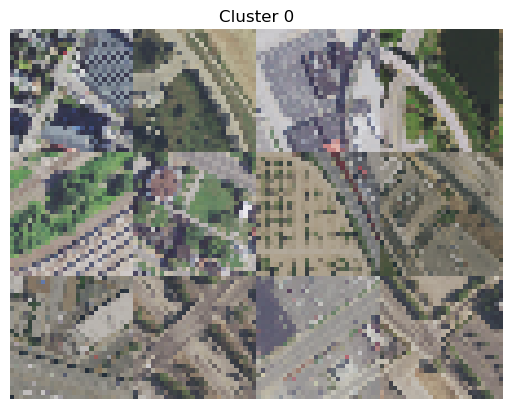

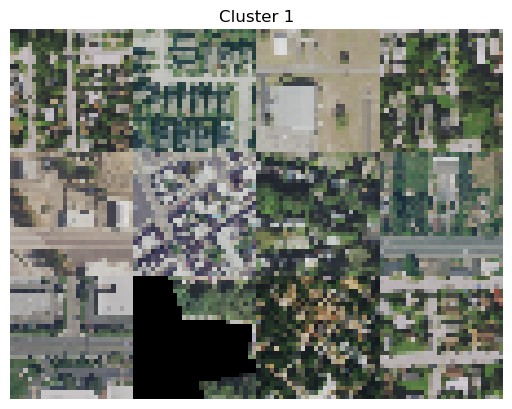

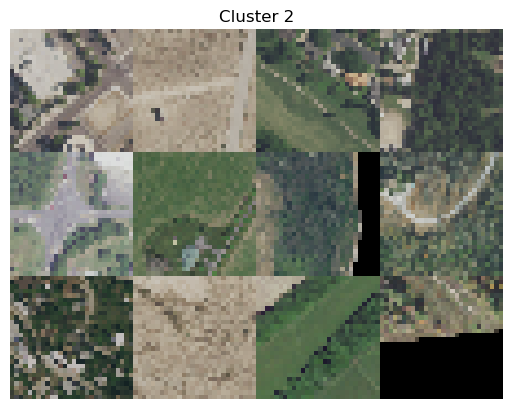

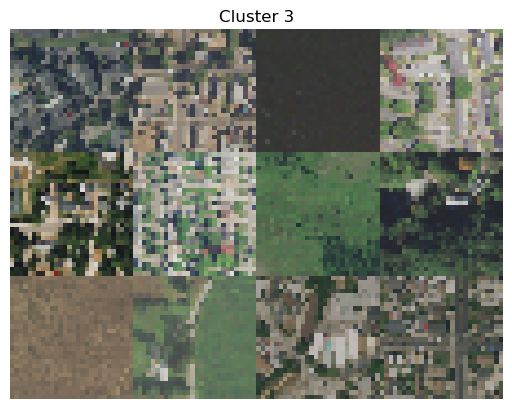

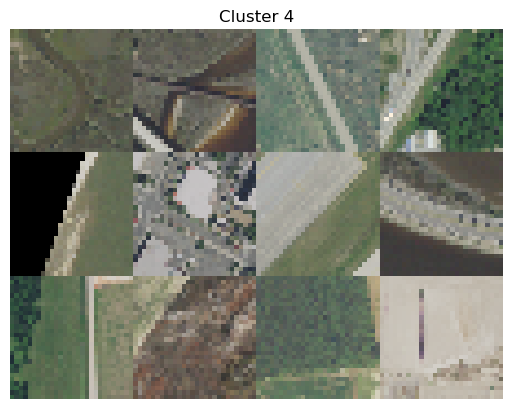

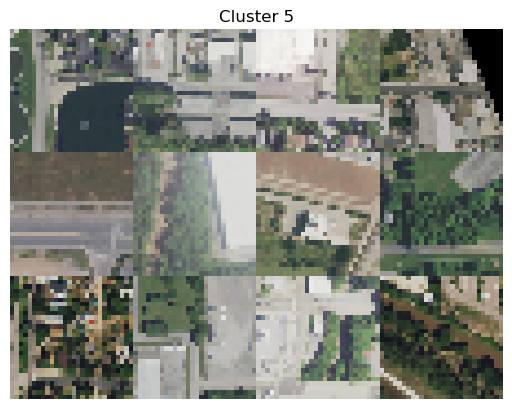

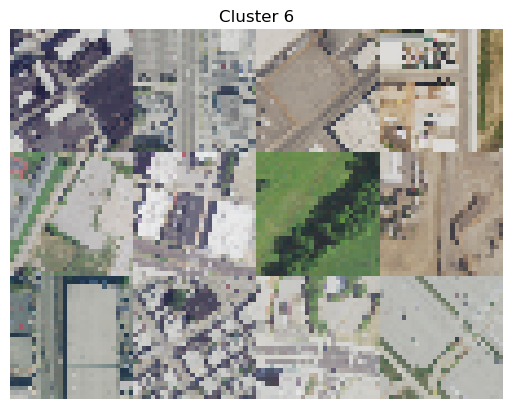

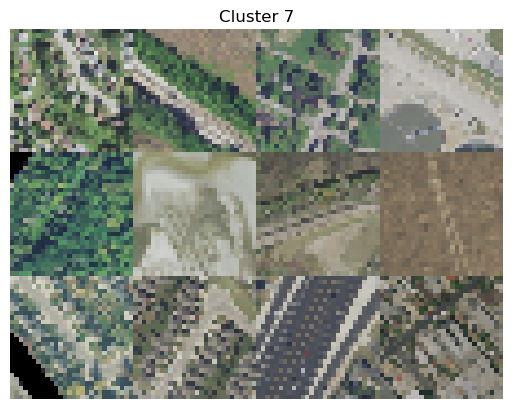

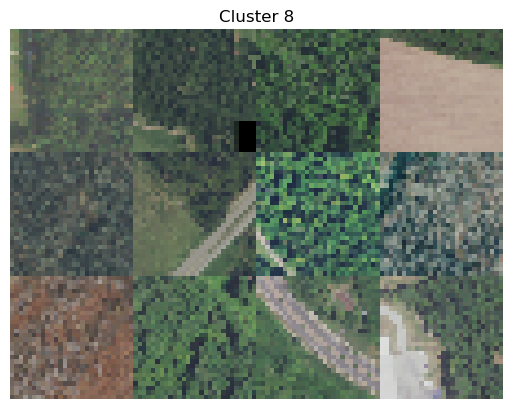

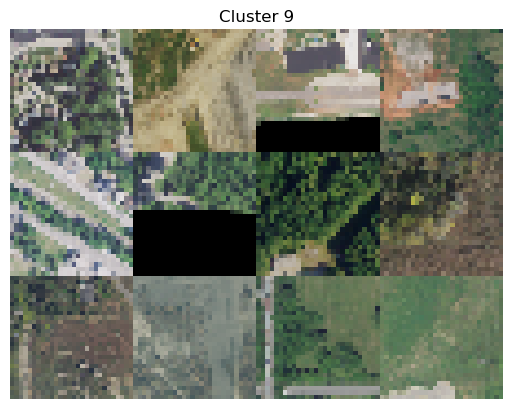

In [9]:
name = "resnet"
for i in range(10):
    samples = clusters[name] == i
    random_samples = np.random.choice(np.where(samples)[0], 12)
    im = np.zeros((28*3, 28*4, 3))
    for j, idx in enumerate(random_samples):
        im[28*(j//4):28*(j//4+1), 28*(j%4):28*(j%4+1)] = dataset[idx][0].permute(1, 2, 0)

    plt.imshow(im)
    plt.axis("off")
    plt.title(f"Cluster {i}")
    plt.show()

/home/giovani/miniconda3/envs/urban_gdp/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


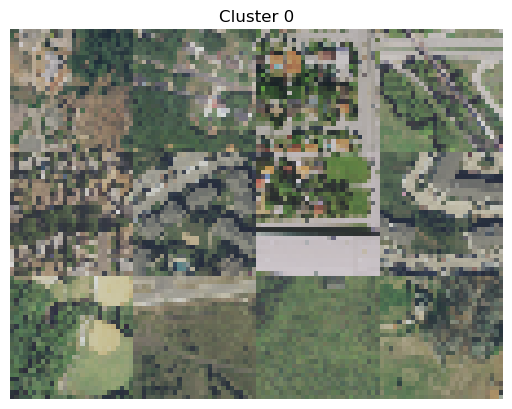

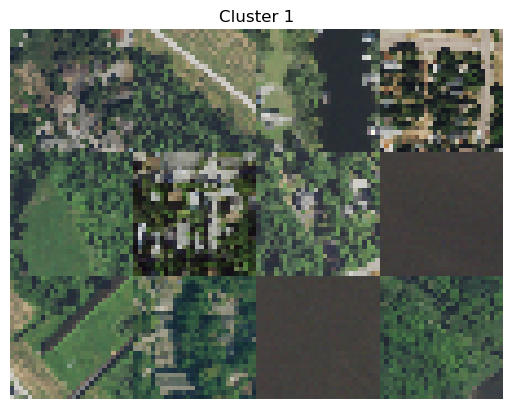

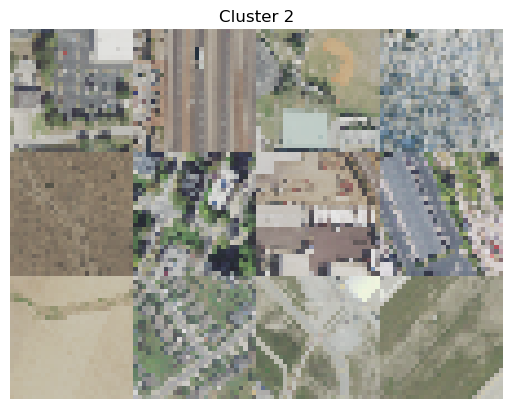

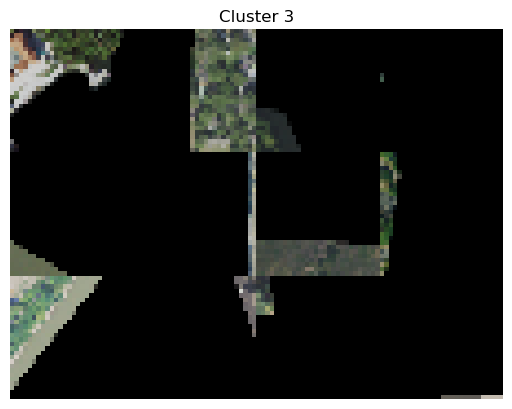

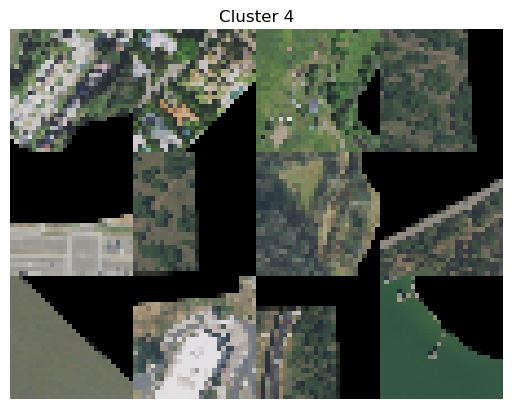

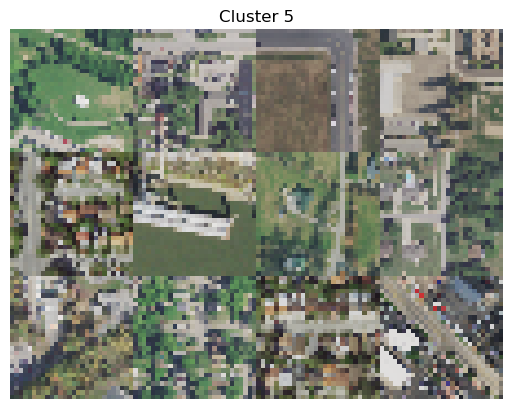

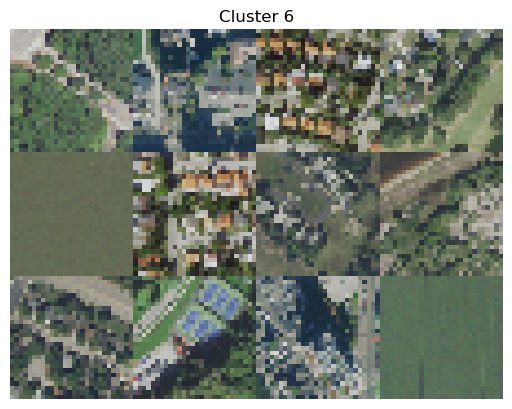

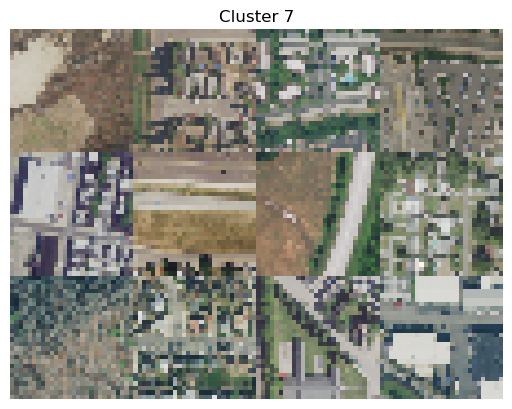

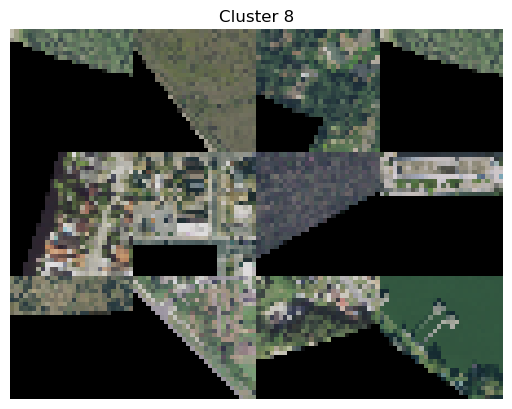

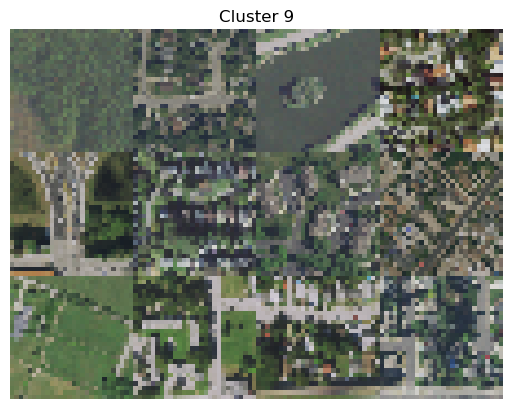

In [12]:
name = "autoencoder"
for i in range(10):
    samples = clusters[name] == i
    if np.sum(samples) == 0:
        continue
    random_samples = np.random.choice(np.where(samples)[0], 12)
    im = np.zeros((28*3, 28*4, 3))
    for j, idx in enumerate(random_samples):
        im[28*(j//4):28*(j//4+1), 28*(j%4):28*(j%4+1)] = dataset[idx][0].permute(1, 2, 0)

    plt.imshow(im)
    plt.axis("off")
    plt.title(f"Cluster {i}")
    plt.show()

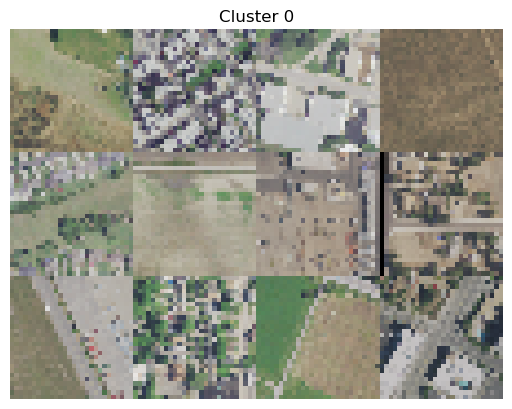

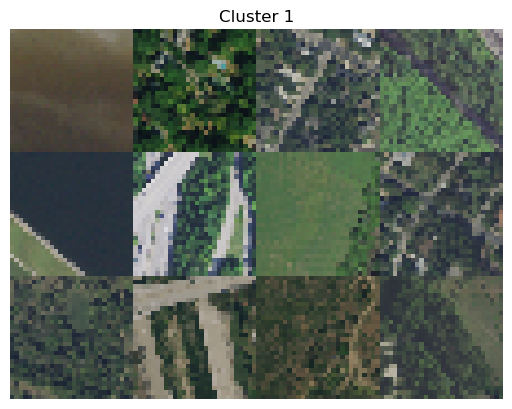

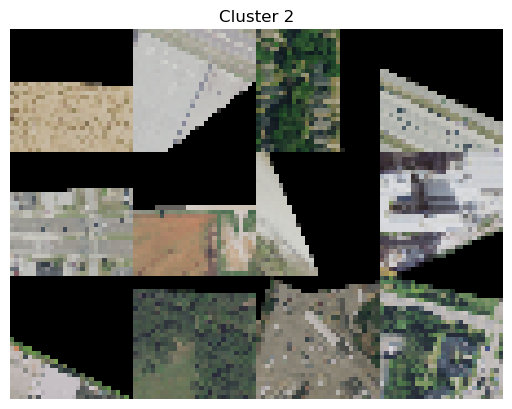

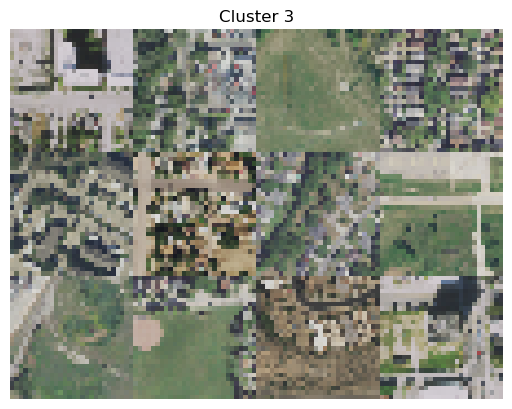

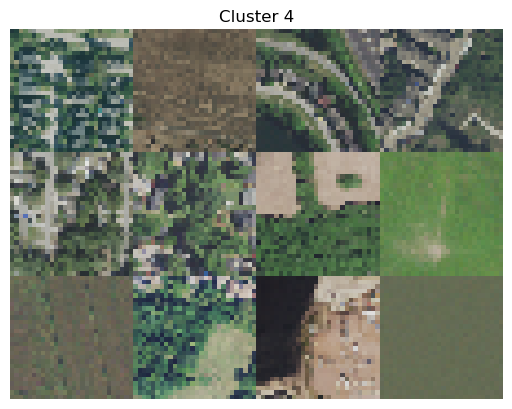

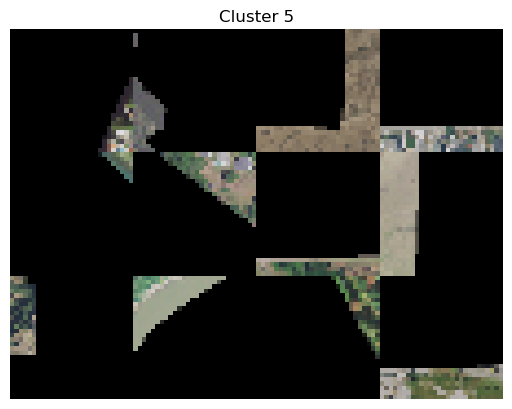

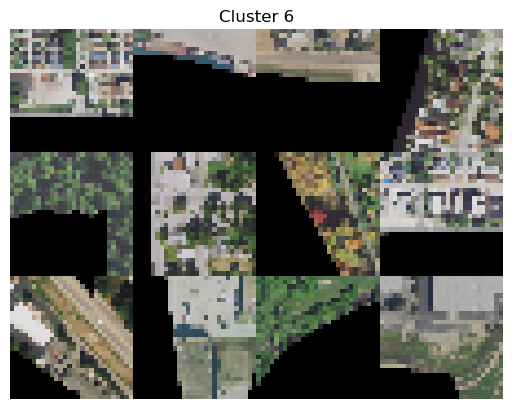

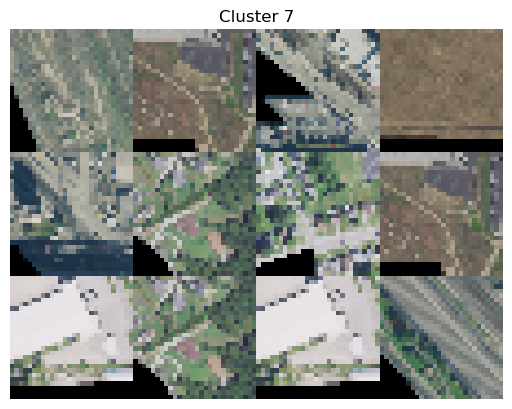

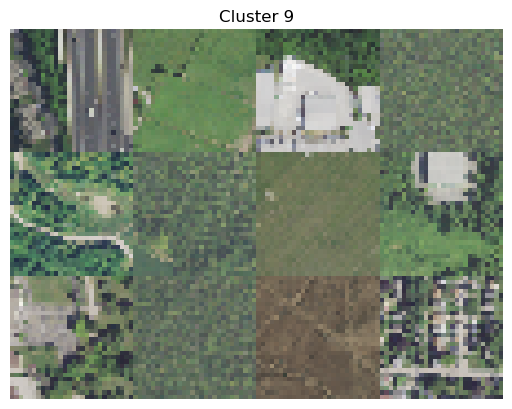

In [13]:
name = "dec"
for i in range(10):
    samples = clusters[name] == i
    if np.sum(samples) == 0:
        continue
    random_samples = np.random.choice(np.where(samples)[0], 12)
    im = np.zeros((28*3, 28*4, 3))
    for j, idx in enumerate(random_samples):
        im[28*(j//4):28*(j//4+1), 28*(j%4):28*(j%4+1)] = dataset[idx][0].permute(1, 2, 0)
    plt.imshow(im)
    plt.axis("off")
    plt.title(f"Cluster {i}")
    plt.show()